In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# For scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# For dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [2]:
# Load cleaned datasets
print("Loading cleaned datasets...\n")

customers = pd.read_csv('customers_data_cleaned.csv')
products = pd.read_csv('products_data_cleaned.csv')
transactions = pd.read_csv('transactions_data_cleaned.csv')

# Convert Transaction_Date to datetime
transactions['Transaction_Date'] = pd.to_datetime(transactions['Transaction_Date'])

print(f"Customers:    {len(customers):,} records")
print(f"Products:     {len(products):,} records")
print(f"Transactions: {len(transactions):,} records")

print("\n✓ Data loaded successfully!")

Loading cleaned datasets...

Customers:    90 records
Products:     18 records
Transactions: 5,818 records

✓ Data loaded successfully!


---
## STEP 1: SELECT RELEVANT FEATURES

In [3]:
print("=" * 80)
print("STEP 1: FEATURE SELECTION - Creating Base Dataset")
print("=" * 80)

# Merge all datasets to create a comprehensive view
print("\n1. Merging datasets...")

# Merge transactions with products
data = transactions.merge(products, on='Product_ID', how='left', suffixes=('_trans', '_prod'))

# Merge with customers
data = data.merge(customers, on='Company_ID', how='left')

print(f"   ✓ Merged dataset created: {data.shape[0]:,} rows × {data.shape[1]} columns")

print("\n2. Current columns in merged dataset:")
for i, col in enumerate(data.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n3. Data types:")
print(data.dtypes.to_string())

STEP 1: FEATURE SELECTION - Creating Base Dataset

1. Merging datasets...
   ✓ Merged dataset created: 5,818 rows × 12 columns

2. Current columns in merged dataset:
    1. Transaction_ID
    2. Company_ID
    3. Product_ID
    4. Quantity
    5. Transaction_Date
    6. Product_Price_trans
    7. Total_Cost
    8. Product_Name
    9. Product_Price_prod
   10. Company_Name
   11. Company_Profit
   12. Address

3. Data types:
Transaction_ID                  int64
Company_ID                      int64
Product_ID                      int64
Quantity                      float64
Transaction_Date       datetime64[ns]
Product_Price_trans           float64
Total_Cost                    float64
Product_Name                   object
Product_Price_prod              int64
Company_Name                   object
Company_Profit                float64
Address                        object


In [4]:
print("\n4. Identifying potentially relevant features...\n")

# Categorize features by type
print("FEATURE CATEGORIZATION:")
print("-" * 60)

id_features = ['Transaction_ID', 'Company_ID', 'Product_ID']
print(f"\nIdentifier Features ({len(id_features)}):")
for f in id_features:
    print(f"  • {f}")

temporal_features = ['Transaction_Date']
print(f"\nTemporal Features ({len(temporal_features)}):")
for f in temporal_features:
    print(f"  • {f} (will create derived features)")

categorical_features = ['Company_Name', 'Product_Name', 'Category', 'City']
print(f"\nCategorical Features ({len(categorical_features)}):")
for f in categorical_features:
    print(f"  • {f}")

numerical_features = ['Quantity', 'Total_Cost', 'Product_Price_trans', 'Product_Price_prod', 'Company_Profit']
print(f"\nNumerical Features ({len(numerical_features)}):")
for f in numerical_features:
    print(f"  • {f}")

print("\n" + "=" * 60)
print("Note: We have price in both transactions and products tables.")
print("We'll use Product_Price_trans (actual transaction price) as primary.")
print("=" * 60)


4. Identifying potentially relevant features...

FEATURE CATEGORIZATION:
------------------------------------------------------------

Identifier Features (3):
  • Transaction_ID
  • Company_ID
  • Product_ID

Temporal Features (1):
  • Transaction_Date (will create derived features)

Categorical Features (4):
  • Company_Name
  • Product_Name
  • Category
  • City

Numerical Features (5):
  • Quantity
  • Total_Cost
  • Product_Price_trans
  • Product_Price_prod
  • Company_Profit

Note: We have price in both transactions and products tables.
We'll use Product_Price_trans (actual transaction price) as primary.


---
## STEP 2: CREATE NEW FEATURES

In [5]:
print("=" * 80)
print("STEP 2: FEATURE CREATION - Part A: Temporal Features")
print("=" * 80)

print("\nExtracting temporal patterns from Transaction_Date...\n")

# Extract date components
data['Year'] = data['Transaction_Date'].dt.year
data['Month'] = data['Transaction_Date'].dt.month
data['Day'] = data['Transaction_Date'].dt.day
data['DayOfWeek'] = data['Transaction_Date'].dt.dayofweek  # 0=Monday, 6=Sunday
data['DayOfYear'] = data['Transaction_Date'].dt.dayofyear
data['Quarter'] = data['Transaction_Date'].dt.quarter
data['WeekOfYear'] = data['Transaction_Date'].dt.isocalendar().week

# Create binary features
data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)  # 1 if Sat/Sun
data['IsMonthStart'] = data['Transaction_Date'].dt.is_month_start.astype(int)
data['IsMonthEnd'] = data['Transaction_Date'].dt.is_month_end.astype(int)
data['IsQuarterStart'] = data['Transaction_Date'].dt.is_quarter_start.astype(int)
data['IsQuarterEnd'] = data['Transaction_Date'].dt.is_quarter_end.astype(int)

# Calculate days since earliest transaction
min_date = data['Transaction_Date'].min()
data['DaysSinceStart'] = (data['Transaction_Date'] - min_date).dt.days

# Create season feature (for Philippines, with 2 main seasons)
def get_season(month):
    if month in [12, 1, 2, 3, 4, 5]:  # Dry season
        return 'Dry'
    else:  # Wet season
        return 'Wet'

data['Season'] = data['Month'].apply(get_season)

print("Created Temporal Features:")
temporal_created = ['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'Quarter', 
                   'WeekOfYear', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 
                   'IsQuarterStart', 'IsQuarterEnd', 'DaysSinceStart', 'Season']
for i, feat in enumerate(temporal_created, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n✓ Total temporal features created: {len(temporal_created)}")

# Show sample
print("\nSample of temporal features:")
display(data[['Transaction_Date'] + temporal_created].head(10))

STEP 2: FEATURE CREATION - Part A: Temporal Features

Extracting temporal patterns from Transaction_Date...

Created Temporal Features:
   1. Year
   2. Month
   3. Day
   4. DayOfWeek
   5. DayOfYear
   6. Quarter
   7. WeekOfYear
   8. IsWeekend
   9. IsMonthStart
  10. IsMonthEnd
  11. IsQuarterStart
  12. IsQuarterEnd
  13. DaysSinceStart
  14. Season

✓ Total temporal features created: 14

Sample of temporal features:


,Transaction_Date,Year,Month,Day,DayOfWeek,DayOfYear,Quarter,WeekOfYear,IsWeekend,IsMonthStart,IsMonthEnd,IsQuarterStart,IsQuarterEnd,DaysSinceStart,Season
0,2024-03-26,2024,3,26,1,86,1,13,0,0,0,0,0,1536,Dry
1,2024-07-09,2024,7,9,1,191,3,28,0,0,0,0,0,1641,Wet
2,2023-09-06,2023,9,6,2,249,3,36,0,0,0,0,0,1334,Wet
3,2021-07-06,2021,7,6,1,187,3,27,0,0,0,0,0,542,Wet
4,2021-07-12,2021,7,12,0,193,3,28,0,0,0,0,0,548,Wet
5,2023-10-31,2023,10,31,1,304,4,44,0,0,1,0,0,1389,Wet
6,2024-02-25,2024,2,25,6,56,1,8,1,0,0,0,0,1506,Dry
7,2021-03-29,2021,3,29,0,88,1,13,0,0,0,0,0,443,Dry
8,2023-03-22,2023,3,22,2,81,1,12,0,0,0,0,0,1166,Dry
9,2023-07-24,2023,7,24,0,205,3,30,0,0,0,0,0,1290,Wet


In [6]:
print("=" * 80)
print("STEP 2: FEATURE CREATION - Part B: Customer Behavior Features")
print("=" * 80)

print("\nAggregating customer purchase patterns...\n")

# Calculate customer-level aggregations
customer_agg = data.groupby('Company_ID').agg({
    'Transaction_ID': 'count',  # Total transactions
    'Total_Cost': ['sum', 'mean', 'std', 'min', 'max'],  # Spending patterns
    'Quantity': ['sum', 'mean', 'std', 'min', 'max'],  # Purchase quantity patterns
    'Product_ID': 'nunique',  # Product variety
    'DaysSinceStart': ['min', 'max']  # Recency and tenure
}).reset_index()

# Flatten column names
customer_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in customer_agg.columns]

# Rename for clarity
customer_agg.rename(columns={
    'Transaction_ID_count': 'Customer_TotalTransactions',
    'Total_Cost_sum': 'Customer_TotalSpending',
    'Total_Cost_mean': 'Customer_AvgSpending',
    'Total_Cost_std': 'Customer_StdSpending',
    'Total_Cost_min': 'Customer_MinSpending',
    'Total_Cost_max': 'Customer_MaxSpending',
    'Quantity_sum': 'Customer_TotalQuantity',
    'Quantity_mean': 'Customer_AvgQuantity',
    'Quantity_std': 'Customer_StdQuantity',
    'Quantity_min': 'Customer_MinQuantity',
    'Quantity_max': 'Customer_MaxQuantity',
    'Product_ID_nunique': 'Customer_UniqueProducts',
    'Category_nunique': 'Customer_UniqueCategories',
    'DaysSinceStart_min': 'Customer_FirstPurchaseDay',
    'DaysSinceStart_max': 'Customer_LastPurchaseDay'
}, inplace=True)

# Calculate additional customer metrics
customer_agg['Customer_AvgDaysBetweenPurchases'] = (
    (customer_agg['Customer_LastPurchaseDay'] - customer_agg['Customer_FirstPurchaseDay']) / 
    customer_agg['Customer_TotalTransactions'].clip(lower=1)
)

# Calculate customer recency (days since last purchase)
max_day = data['DaysSinceStart'].max()
customer_agg['Customer_DaysSinceLastPurchase'] = max_day - customer_agg['Customer_LastPurchaseDay']

# Fill NaN in std columns (happens when customer has only 1 transaction)
customer_agg['Customer_StdSpending'].fillna(0, inplace=True)
customer_agg['Customer_StdQuantity'].fillna(0, inplace=True)

# Merge back to main dataset
data = data.merge(customer_agg, on='Company_ID', how='left')

print("Created Customer Behavior Features:")
customer_features = [col for col in customer_agg.columns if col.startswith('Customer_')]
for i, feat in enumerate(customer_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n✓ Total customer features created: {len(customer_features)}")

# Show sample
print("\nSample of customer features:")
display(data[['Company_ID', 'Company_Name'] + customer_features[:8]].drop_duplicates('Company_ID').head())

STEP 2: FEATURE CREATION - Part B: Customer Behavior Features

Aggregating customer purchase patterns...

Created Customer Behavior Features:
   1. Customer_TotalTransactions
   2. Customer_TotalSpending
   3. Customer_AvgSpending
   4. Customer_StdSpending
   5. Customer_MinSpending
   6. Customer_MaxSpending
   7. Customer_TotalQuantity
   8. Customer_AvgQuantity
   9. Customer_StdQuantity
  10. Customer_MinQuantity
  11. Customer_MaxQuantity
  12. Customer_UniqueProducts
  13. Customer_FirstPurchaseDay
  14. Customer_LastPurchaseDay
  15. Customer_AvgDaysBetweenPurchases
  16. Customer_DaysSinceLastPurchase

✓ Total customer features created: 16

Sample of customer features:


,Company_ID,Company_Name,Customer_TotalTransactions,Customer_TotalSpending,Customer_AvgSpending,Customer_StdSpending,Customer_MinSpending,Customer_MaxSpending,Customer_TotalQuantity,Customer_AvgQuantity
0,88,Elite Consulting 88,63,93464000.0,1.483556e+06,946294.333564,112000.0,3724000.0,713.0,11.317460
1,29,Sky Industries 29,49,83479200.0,1.703657e+06,930770.333290,84000.0,4480000.0,588.0,12.000000
2,85,Green Ventures 85,77,107783200.0,1.399782e+06,827223.471482,156800.0,3808000.0,802.0,10.415584
3,47,Green Industries 47,42,51060800.0,1.215733e+06,755029.428167,100800.0,3584000.0,435.0,10.357143
4,80,Green Partners 80,79,116088000.0,1.469468e+06,814078.163504,168000.0,3920000.0,869.0,11.000000


In [7]:
print("=" * 80)
print("STEP 2: FEATURE CREATION - Part C: Product Features")
print("=" * 80)

print("\nAggregating product popularity and patterns...\n")

# Calculate product-level aggregations
product_agg = data.groupby('Product_ID').agg({
    'Transaction_ID': 'count',  # Product popularity
    'Total_Cost': ['sum', 'mean', 'std'],  # Revenue metrics
    'Quantity': ['sum', 'mean', 'std'],  # Sales volume
    'Company_ID': 'nunique'  # Customer reach
}).reset_index()

# Flatten column names
product_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in product_agg.columns]

# Rename for clarity
product_agg.rename(columns={
    'Transaction_ID_count': 'Product_TotalSales',
    'Total_Cost_sum': 'Product_TotalRevenue',
    'Total_Cost_mean': 'Product_AvgRevenue',
    'Total_Cost_std': 'Product_StdRevenue',
    'Quantity_sum': 'Product_TotalQuantitySold',
    'Quantity_mean': 'Product_AvgQuantity',
    'Quantity_std': 'Product_StdQuantity',
    'Company_ID_nunique': 'Product_UniqueCustomers'
}, inplace=True)

# Calculate product popularity rank (higher sales = higher rank)
product_agg['Product_PopularityRank'] = product_agg['Product_TotalSales'].rank(ascending=False, method='dense')

# Calculate product market share (as % of total transactions)
total_transactions = len(data)
product_agg['Product_MarketShare'] = (product_agg['Product_TotalSales'] / total_transactions) * 100

# Fill NaN in std columns
product_agg['Product_StdRevenue'].fillna(0, inplace=True)
product_agg['Product_StdQuantity'].fillna(0, inplace=True)

# Merge back to main dataset
data = data.merge(product_agg, on='Product_ID', how='left')

print("Created Product Features:")
product_features = [col for col in product_agg.columns if col.startswith('Product_') and col != 'Product_ID']
for i, feat in enumerate(product_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n✓ Total product features created: {len(product_features)}")

# Show sample
print("\nSample of product features:")
display(data[['Product_ID', 'Product_Name'] + product_features[:8]].drop_duplicates('Product_ID').head())

STEP 2: FEATURE CREATION - Part C: Product Features

Aggregating product popularity and patterns...

Created Product Features:
   1. Product_TotalSales
   2. Product_TotalRevenue
   3. Product_AvgRevenue
   4. Product_StdRevenue
   5. Product_TotalQuantitySold
   6. Product_AvgQuantity
   7. Product_StdQuantity
   8. Product_UniqueCustomers
   9. Product_PopularityRank
  10. Product_MarketShare

✓ Total product features created: 10

Sample of product features:


,Product_ID,Product_Name,Product_TotalSales,Product_TotalRevenue,Product_AvgRevenue,Product_StdRevenue,Product_TotalQuantitySold,Product_AvgQuantity,Product_StdQuantity,Product_UniqueCustomers
0,6,RevenueVue Dashboard,368,687321600.0,1.867722e+06,950543.362501,3910.0,10.625000,5.275580,88
1,19,EcoNomix Modeler,324,329789600.0,1.017869e+06,537376.616442,3386.0,10.450617,5.520076,89
2,12,BudgetMaster Pro,309,287700000.0,9.310680e+05,469496.509720,3270.0,10.582524,5.387318,85
3,3,TrendWise Forecaster,334,360931200.0,1.080632e+06,546497.934548,3392.0,10.155689,5.436476,84
4,11,OptiFlow Automation,345,588313600.0,1.705257e+06,853435.341358,3850.0,11.159420,5.361966,88


In [8]:
print("=" * 80)
print("STEP 2: FEATURE CREATION - Part D: Interaction & Derived Features")
print("=" * 80)

print("\nCreating features from relationships between existing variables...\n")

# Transaction-level derived features
data['PricePerUnit'] = data['Total_Cost'] / data['Quantity']
data['DiscountAmount'] = data['Product_Price_prod'] - data['Product_Price_trans']
data['DiscountPercentage'] = ((data['Product_Price_prod'] - data['Product_Price_trans']) / 
                               data['Product_Price_prod'].clip(lower=0.01)) * 100
data['DiscountPercentage'] = data['DiscountPercentage'].clip(lower=0, upper=100)  # Cap at reasonable range

# Customer profitability metrics
data['SpendingVsProfitRatio'] = (data['Customer_TotalSpending'] / 
                                  data['Company_Profit'].clip(lower=1))

# Relative purchase size (compared to customer's average)
data['RelativePurchaseSize'] = (data['Total_Cost'] / 
                                 data['Customer_AvgSpending'].clip(lower=1))

# Relative quantity (compared to customer's average)
data['RelativeQuantity'] = (data['Quantity'] / 
                             data['Customer_AvgQuantity'].clip(lower=1))

# Product affinity (how much this customer spends on this product vs others)
data['CustomerProductAffinity'] = (data['Total_Cost'] / 
                                    data['Product_AvgRevenue'].clip(lower=1))

# Customer loyalty score (based on transaction frequency and recency)
data['CustomerLoyaltyScore'] = (
    data['Customer_TotalTransactions'] / 
    (data['Customer_DaysSinceLastPurchase'] + 1)
)

# Product penetration (what % of customer's transactions is this product)
product_per_customer = data.groupby(['Company_ID', 'Product_ID']).size().reset_index(name='CustomerProduct_Count')
data = data.merge(product_per_customer, on=['Company_ID', 'Product_ID'], how='left')
data['ProductPenetrationRate'] = (
    data['CustomerProduct_Count'] / data['Customer_TotalTransactions']
) * 100

# High-value transaction flag
high_value_threshold = data['Total_Cost'].quantile(0.75)
data['IsHighValueTransaction'] = (data['Total_Cost'] >= high_value_threshold).astype(int)

# Bulk purchase flag
bulk_threshold = data['Quantity'].quantile(0.75)
data['IsBulkPurchase'] = (data['Quantity'] >= bulk_threshold).astype(int)

print("Created Interaction & Derived Features:")
interaction_features = [
    'PricePerUnit', 'DiscountAmount', 'DiscountPercentage',
    'SpendingVsProfitRatio', 'RelativePurchaseSize', 'RelativeQuantity',
    'CustomerProductAffinity', 'CustomerLoyaltyScore', 
    'CustomerProduct_Count', 'ProductPenetrationRate',
    'IsHighValueTransaction', 'IsBulkPurchase'
]
for i, feat in enumerate(interaction_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n✓ Total interaction features created: {len(interaction_features)}")

# Show sample
print("\nSample of interaction features:")
display(data[['Company_ID', 'Product_ID'] + interaction_features[:8]].head())

STEP 2: FEATURE CREATION - Part D: Interaction & Derived Features

Creating features from relationships between existing variables...

Created Interaction & Derived Features:
   1. PricePerUnit
   2. DiscountAmount
   3. DiscountPercentage
   4. SpendingVsProfitRatio
   5. RelativePurchaseSize
   6. RelativeQuantity
   7. CustomerProductAffinity
   8. CustomerLoyaltyScore
   9. CustomerProduct_Count
  10. ProductPenetrationRate
  11. IsHighValueTransaction
  12. IsBulkPurchase

✓ Total interaction features created: 12

Sample of interaction features:


,Company_ID,Product_ID,PricePerUnit,DiscountAmount,DiscountPercentage,SpendingVsProfitRatio,RelativePurchaseSize,RelativeQuantity,CustomerProductAffinity,CustomerLoyaltyScore
0,88,6,107520.0,-15179.15,0.000000,1230.599078,0.724745,0.883590,0.575675,1.431818
1,29,19,89250.0,-2730.99,0.000000,1347.481921,0.838197,1.333333,1.402931,1.400000
2,85,12,84000.0,-46556.44,0.000000,949.882788,0.720112,1.152120,1.082628,0.987179
3,47,3,88200.0,1224.39,1.214673,1640.244137,0.580390,0.772414,0.652951,1.235294
4,80,11,156800.0,-3858.68,0.000000,1043.703417,0.426821,0.363636,0.367804,1.462963


In [9]:
print("=" * 80)
print("FEATURE CREATION SUMMARY")
print("=" * 80)

print(f"\nOriginal features: {transactions.shape[1] + products.shape[1] + customers.shape[1] - 2}")
print(f"Total features now: {data.shape[1]}")
print(f"New features created: {data.shape[1] - (transactions.shape[1] + products.shape[1] + customers.shape[1] - 2)}")

print("\nFeature Categories Created:")
print(f"  1. Temporal Features:      {len(temporal_created)}")
print(f"  2. Customer Features:      {len(customer_features)}")
print(f"  3. Product Features:       {len(product_features)}")
print(f"  4. Interaction Features:   {len(interaction_features)}")
print(f"  {'─' * 40}")
print(f"  Total New Features:        {len(temporal_created) + len(customer_features) + len(product_features) + len(interaction_features)}")

print(f"\n✓ Feature creation complete!")
print(f"  Dataset shape: {data.shape[0]:,} rows × {data.shape[1]} columns")

FEATURE CREATION SUMMARY

Original features: 12
Total features now: 64
New features created: 52

Feature Categories Created:
  1. Temporal Features:      14
  2. Customer Features:      16
  3. Product Features:       10
  4. Interaction Features:   12
  ────────────────────────────────────────
  Total New Features:        52

✓ Feature creation complete!
  Dataset shape: 5,818 rows × 64 columns


---
## STEP 3: ENCODE CATEGORICAL DATA

In [10]:
print("=" * 80)
print("STEP 3: CATEGORICAL ENCODING - Preparation")
print("=" * 80)

print("\nIdentifying categorical variables...\n")

# Identify categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Categorical variables found:")
for i, col in enumerate(categorical_cols, 1):
    unique_vals = data[col].nunique()
    print(f"  {i:2d}. {col:<25} ({unique_vals:3d} unique values)")

print("\nEncoding Strategy:")
print("  • Label Encoding: For variables with natural ordering or many categories")
print("  • One-Hot Encoding: For nominal variables with few categories")
print("  • Drop: Company_Name and Product_Name (already encoded via ID)")

STEP 3: CATEGORICAL ENCODING - Preparation

Identifying categorical variables...

Categorical variables found:
   1. Product_Name              ( 18 unique values)
   2. Company_Name              ( 90 unique values)
   3. Address                   ( 87 unique values)
   4. Season                    (  2 unique values)

Encoding Strategy:
  • Label Encoding: For variables with natural ordering or many categories
  • One-Hot Encoding: For nominal variables with few categories
  • Drop: Company_Name and Product_Name (already encoded via ID)


In [11]:
print("=" * 80)
print("STEP 3: CATEGORICAL ENCODING - Label Encoding")
print("=" * 80)

print("\nApplying Label Encoding to high-cardinality variables...\n")

# Create a copy for encoding
data_encoded = data.copy()

# Initialize label encoder
le = LabelEncoder()

# Encode City (many unique cities)
if 'City' in data_encoded.columns:
    data_encoded['City_Encoded'] = le.fit_transform(data_encoded['City'])
    print(f"✓ City encoded: {data_encoded['City'].nunique()} cities → values 0-{data_encoded['City_Encoded'].max()}")

# Encode Season
if 'Season' in data_encoded.columns:
    data_encoded['Season_Encoded'] = le.fit_transform(data_encoded['Season'])
    print(f"✓ Season encoded: {data_encoded['Season'].nunique()} seasons → values 0-{data_encoded['Season_Encoded'].max()}")

print("\n✓ Label encoding complete!")

STEP 3: CATEGORICAL ENCODING - Label Encoding

Applying Label Encoding to high-cardinality variables...

✓ Season encoded: 2 seasons → values 0-1

✓ Label encoding complete!


In [12]:
print("=" * 80)
print("STEP 3: CATEGORICAL ENCODING - One-Hot Encoding")
print("=" * 80)

print("\nApplying One-Hot Encoding to low-cardinality variables...\n")

# One-hot encode Category (product categories)
if 'Category' in data_encoded.columns:
    category_dummies = pd.get_dummies(data_encoded['Category'], prefix='Category', drop_first=True)
    data_encoded = pd.concat([data_encoded, category_dummies], axis=1)
    print(f"✓ Category one-hot encoded: {data_encoded['Category'].nunique()} categories → {len(category_dummies.columns)} binary features")
    print(f"  Created features: {', '.join(category_dummies.columns.tolist())}")

print("\n✓ One-hot encoding complete!")

# Drop original categorical columns that we've encoded (keep names for reference)
cols_to_drop = ['Season']  # Keep Company_Name and Product_Name for interpretation
data_encoded.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"\n✓ Categorical encoding complete!")
print(f"  Dataset shape: {data_encoded.shape[0]:,} rows × {data_encoded.shape[1]} columns")

STEP 3: CATEGORICAL ENCODING - One-Hot Encoding

Applying One-Hot Encoding to low-cardinality variables...


✓ One-hot encoding complete!

✓ Categorical encoding complete!
  Dataset shape: 5,818 rows × 64 columns


---
## STEP 4: HANDLE MISSING DATA

In [13]:
print("=" * 80)
print("STEP 4: MISSING DATA HANDLING")
print("=" * 80)

print("\n1. Checking for missing values...\n")

# Count missing values
missing_counts = data_encoded.isnull().sum()
missing_percent = (missing_counts / len(data_encoded)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print("Columns with missing values:")
    print(missing_df.to_string(index=False))
    print(f"\nTotal columns with missing data: {len(missing_df)}")
else:
    print("✓ No missing values found in the dataset!")
    print("  All features are complete after data preprocessing.")

STEP 4: MISSING DATA HANDLING

1. Checking for missing values...

✓ No missing values found in the dataset!
  All features are complete after data preprocessing.


In [14]:
print("\n2. Handling missing values (if any)...\n")

# Create a copy for imputation
data_clean = data_encoded.copy()

# Check if there are any infinity values from our calculations
print("Checking for infinity values from feature calculations...")
inf_cols = []
for col in data_clean.select_dtypes(include=[np.number]).columns:
    if np.isinf(data_clean[col]).any():
        inf_cols.append(col)
        inf_count = np.isinf(data_clean[col]).sum()
        print(f"  • {col}: {inf_count} infinity values")

if inf_cols:
    print("\nReplacing infinity values with NaN for proper handling...")
    data_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("✓ Infinity values replaced")

# Handle any NaN values created
numerical_cols = data_clean.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols:
    if data_clean[col].isna().any():
        # Use median for imputation (robust to outliers)
        median_val = data_clean[col].median()
        data_clean[col].fillna(median_val, inplace=True)
        print(f"  • Imputed {col} with median: {median_val:.2f}")

print("\n✓ Missing data handling complete!")
print(f"  Final dataset: {data_clean.shape[0]:,} rows × {data_clean.shape[1]} columns")
print(f"  Missing values remaining: {data_clean.isnull().sum().sum()}")


2. Handling missing values (if any)...

Checking for infinity values from feature calculations...

✓ Missing data handling complete!
  Final dataset: 5,818 rows × 64 columns
  Missing values remaining: 0


---
## STEP 5: SCALE AND NORMALIZE FEATURES

In [15]:
print("=" * 80)
print("STEP 5: FEATURE SCALING - Preparation")
print("=" * 80)

print("\nPreparing features for scaling...\n")

# Separate features that should NOT be scaled
id_cols = ['Transaction_ID', 'Company_ID', 'Product_ID']
binary_cols = [col for col in data_clean.columns if col.startswith('Is') or 
               col.startswith('Category_')]
encoded_cols = ['City_Encoded', 'Season_Encoded']
reference_cols = ['Company_Name', 'Product_Name', 'City', 'Category', 'Transaction_Date']

# Columns to exclude from scaling
exclude_from_scaling = id_cols + binary_cols + encoded_cols + reference_cols
exclude_from_scaling = [col for col in exclude_from_scaling if col in data_clean.columns]

# Identify numerical columns to scale
numerical_cols = data_clean.select_dtypes(include=[np.number]).columns.tolist()
cols_to_scale = [col for col in numerical_cols if col not in exclude_from_scaling]

print(f"Total numerical columns: {len(numerical_cols)}")
print(f"Columns to scale: {len(cols_to_scale)}")
print(f"Excluded from scaling: {len(exclude_from_scaling)}")

print("\nFeatures that will be scaled:")
for i, col in enumerate(cols_to_scale[:20], 1):  # Show first 20
    print(f"  {i:2d}. {col}")
if len(cols_to_scale) > 20:
    print(f"  ... and {len(cols_to_scale) - 20} more")

STEP 5: FEATURE SCALING - Preparation

Preparing features for scaling...

Total numerical columns: 60
Columns to scale: 49
Excluded from scaling: 14

Features that will be scaled:
   1. Quantity
   2. Product_Price_trans
   3. Total_Cost
   4. Product_Price_prod
   5. Company_Profit
   6. Year
   7. Month
   8. Day
   9. DayOfWeek
  10. DayOfYear
  11. Quarter
  12. WeekOfYear
  13. DaysSinceStart
  14. Customer_TotalTransactions
  15. Customer_TotalSpending
  16. Customer_AvgSpending
  17. Customer_StdSpending
  18. Customer_MinSpending
  19. Customer_MaxSpending
  20. Customer_TotalQuantity
  ... and 29 more


In [16]:
print("=" * 80)
print("STEP 5: FEATURE SCALING - Application")
print("=" * 80)

# Create copies for different scaling methods
data_standard = data_clean.copy()
data_minmax = data_clean.copy()
data_robust = data_clean.copy()

# 1. Standard Scaling (Z-score normalization)
print("\n1. Applying Standard Scaling (mean=0, std=1)...")
scaler_standard = StandardScaler()
data_standard[cols_to_scale] = scaler_standard.fit_transform(data_standard[cols_to_scale])
print("   ✓ Standard scaling complete")

# 2. Min-Max Scaling (to [0,1] range)
print("\n2. Applying Min-Max Scaling (range [0,1])...")
scaler_minmax = MinMaxScaler()
data_minmax[cols_to_scale] = scaler_minmax.fit_transform(data_minmax[cols_to_scale])
print("   ✓ Min-Max scaling complete")

# 3. Robust Scaling (using median and IQR, robust to outliers)
print("\n3. Applying Robust Scaling (median-based)...")
scaler_robust = RobustScaler()
data_robust[cols_to_scale] = scaler_robust.fit_transform(data_robust[cols_to_scale])
print("   ✓ Robust scaling complete")

print("\n" + "=" * 80)
print("SCALING COMPARISON")
print("=" * 80)

# Show example of scaling effects
sample_col = 'Total_Cost' if 'Total_Cost' in cols_to_scale else cols_to_scale[0]
comparison_df = pd.DataFrame({
    'Original': data_clean[sample_col].head(10),
    'Standard': data_standard[sample_col].head(10),
    'MinMax': data_minmax[sample_col].head(10),
    'Robust': data_robust[sample_col].head(10)
})

print(f"\nExample: {sample_col} scaling comparison")
print(comparison_df.to_string())

print("\n✓ All scaling methods applied successfully!")
print("\nRecommendation: Use Standard Scaling for most ML algorithms.")
print("                Use Robust Scaling if outliers are a concern.")

STEP 5: FEATURE SCALING - Application

1. Applying Standard Scaling (mean=0, std=1)...
   ✓ Standard scaling complete

2. Applying Min-Max Scaling (range [0,1])...
   ✓ Min-Max scaling complete

3. Applying Robust Scaling (median-based)...
   ✓ Robust scaling complete

SCALING COMPARISON

Example: Total_Cost scaling comparison
    Original  Standard    MinMax    Robust
0  1075200.0 -0.425657  0.225478 -0.242424
1  1428000.0 -0.021989  0.305732  0.075758
2  1008000.0 -0.502547  0.210191 -0.303030
3   705600.0 -0.848548  0.141401 -0.575758
4   627200.0 -0.938253  0.123567 -0.646465
5  1792000.0  0.394495  0.388535  0.404040
6  1344000.0 -0.118100  0.286624  0.000000
7  1120000.0 -0.374398  0.235669 -0.202020
8  1428000.0 -0.021989  0.305732  0.075758
9   302400.0 -1.309884  0.049682 -0.939394

✓ All scaling methods applied successfully!

Recommendation: Use Standard Scaling for most ML algorithms.
                Use Robust Scaling if outliers are a concern.


---
## STEP 6: REDUCE DIMENSIONALITY

In [17]:
print("=" * 80)
print("STEP 6: DIMENSIONALITY REDUCTION - Part A: Correlation Analysis")
print("=" * 80)

print("\nAnalyzing feature correlations to identify redundancy...\n")

# Select only numerical features for correlation
numerical_features = data_standard.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns
numerical_features = [col for col in numerical_features if col not in id_cols]

# Calculate correlation matrix
correlation_matrix = data_standard[numerical_features].corr()

# Find highly correlated pairs (|correlation| > 0.9)
high_corr_threshold = 0.9
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > {high_corr_threshold}):")
    print("\n{:<40} {:<40} {:>12}".format('Feature 1', 'Feature 2', 'Correlation'))
    print("─" * 95)
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:15]:
        print("{:<40} {:<40} {:>12.4f}".format(feat1, feat2, corr))
    if len(high_corr_pairs) > 15:
        print(f"... and {len(high_corr_pairs) - 15} more pairs")
else:
    print(f"No highly correlated feature pairs found (threshold: {high_corr_threshold})")

# Identify features to potentially remove
features_to_consider_removing = set()
for feat1, feat2, corr in high_corr_pairs:
    # Keep the feature that appears first alphabetically (arbitrary but consistent)
    features_to_consider_removing.add(max(feat1, feat2))

print(f"\nFeatures to consider removing due to high correlation: {len(features_to_consider_removing)}")
if features_to_consider_removing:
    print("(Note: Review these carefully - some may still provide unique value)")

STEP 6: DIMENSIONALITY REDUCTION - Part A: Correlation Analysis

Analyzing feature correlations to identify redundancy...

Found 26 highly correlated feature pairs (|r| > 0.9):

Feature 1                                Feature 2                                 Correlation
───────────────────────────────────────────────────────────────────────────────────────────────
Customer_LastPurchaseDay                 Customer_DaysSinceLastPurchase                -1.0000
Product_TotalSales                       Product_MarketShare                            1.0000
Product_Price_prod                       Product_AvgRevenue                             0.9973
Month                                    DayOfYear                                      0.9965
Product_Price_prod                       Product_StdRevenue                             0.9932
Product_AvgRevenue                       Product_StdRevenue                             0.9927
Quantity                                 RelativeQuantity    

STEP 6: DIMENSIONALITY REDUCTION - Part B: Feature Importance

Calculating feature importance for predicting customer spending...

Analyzing 56 features to predict Total_Cost
Sample size: 5,818 transactions

Computing mutual information scores...



Top 20 Most Important Features:
────────────────────────────────────────────────────────────
Rank Feature                                         MI Score
────────────────────────────────────────────────────────────
1    CustomerProductAffinity                           4.8016
2    PricePerUnit                                      3.1570
3    RelativePurchaseSize                              2.4390
4    Product_Price_prod                                1.8327
5    Product_TotalQuantitySold                         1.8201
6    Product_AvgQuantity                               1.8194
7    Product_StdRevenue                                1.8192
8    Product_StdQuantity                               1.8177
9    Product_AvgRevenue                                1.8175
10   Product_TotalRevenue                              1.8119
11   Product_TotalSales                                1.6253
12   Product_PopularityRank                            1.6241
13   Product_MarketShare               

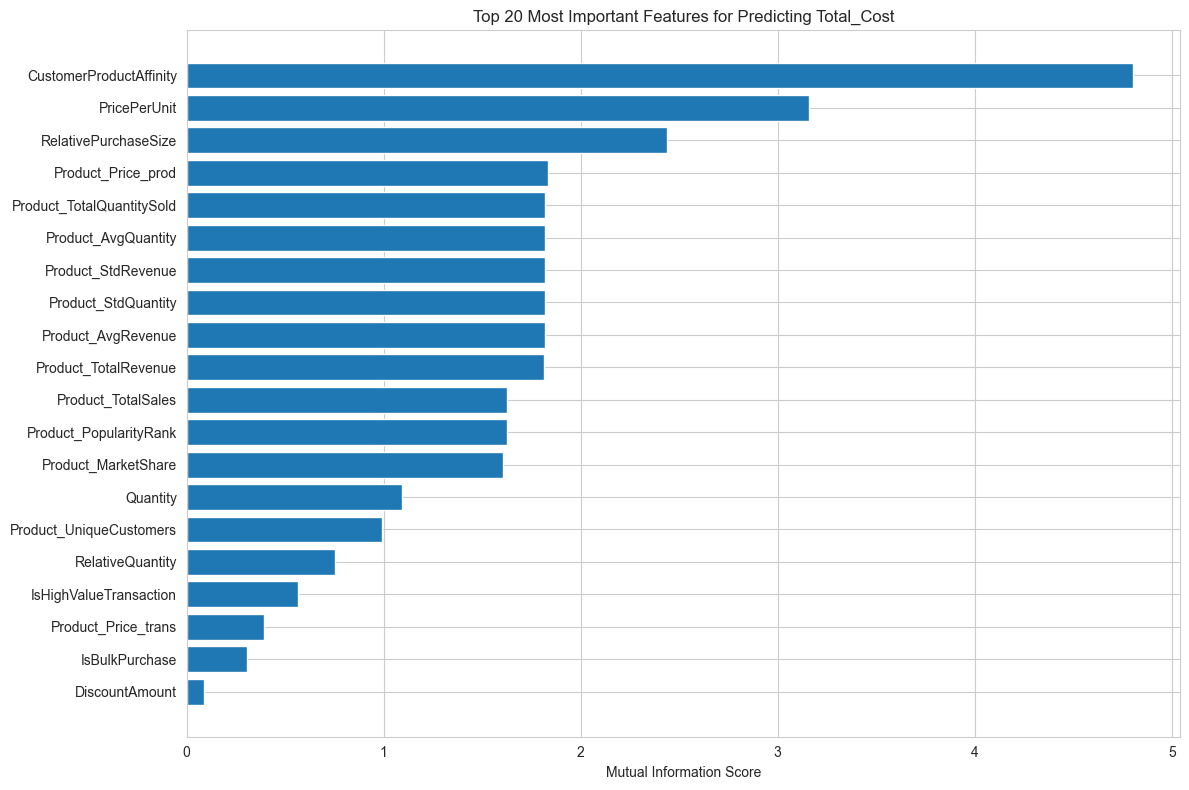


✓ Feature importance analysis complete!


In [18]:
print("=" * 80)
print("STEP 6: DIMENSIONALITY REDUCTION - Part B: Feature Importance")
print("=" * 80)

print("\nCalculating feature importance for predicting customer spending...\n")

# Define target variable (what we want to predict)
# For customer purchase behavior, we'll use Total_Cost as proxy for purchase value
target = 'Total_Cost'

# Prepare features for importance analysis
feature_cols = [col for col in numerical_features if col != target and col not in id_cols]

X = data_standard[feature_cols].copy()
y = data_clean[target].copy()  # Use original scale for y

# Remove any rows with NaN
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X = X[valid_idx]
y = y[valid_idx]

print(f"Analyzing {len(feature_cols)} features to predict {target}")
print(f"Sample size: {len(X):,} transactions\n")

# Calculate feature importance using mutual information
print("Computing mutual information scores...")
mi_scores = mutual_info_regression(X, y, random_state=42)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nTop 20 Most Important Features:")
print("─" * 60)
print("{:<4} {:<45} {:>10}".format('Rank', 'Feature', 'MI Score'))
print("─" * 60)
for idx, row in feature_importance.head(20).iterrows():
    rank = feature_importance.index.get_loc(idx) + 1
    print("{:<4} {:<45} {:>10.4f}".format(rank, row['Feature'], row['MI_Score']))

# Visualize top features
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)
plt.barh(range(top_n), top_features['MI_Score'].values)
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Mutual Information Score')
plt.title(f'Top {top_n} Most Important Features for Predicting {target}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete!")

STEP 6: DIMENSIONALITY REDUCTION - Part C: PCA (Principal Component Analysis)

Applying PCA to reduce dimensionality while preserving variance...

Original feature space: 57 dimensions

Components needed to preserve variance:
  • 90% variance: 20 components (from 57 features)
  • 95% variance: 24 components (from 57 features)
  • 99% variance: 31 components (from 57 features)

✓ PCA transformation complete!
  Reduced from 57 features to 24 principal components
  Variance preserved: 96.03%


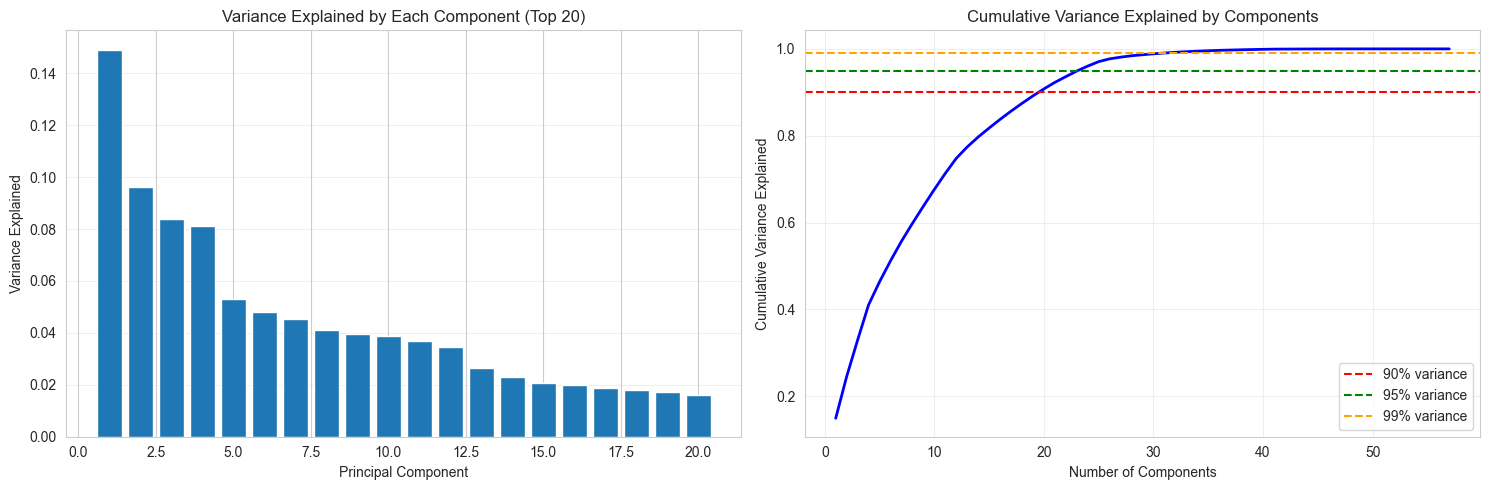

In [19]:
print("=" * 80)
print("STEP 6: DIMENSIONALITY REDUCTION - Part C: PCA (Principal Component Analysis)")
print("=" * 80)

print("\nApplying PCA to reduce dimensionality while preserving variance...\n")

# Use the standardized data for PCA
pca_features = [col for col in numerical_features if col not in id_cols]
X_pca = data_standard[pca_features].copy()

# Remove any NaN values
X_pca = X_pca.fillna(0)

print(f"Original feature space: {X_pca.shape[1]} dimensions")

# Apply PCA to find optimal number of components
pca_full = PCA()
pca_full.fit(X_pca)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for different variance thresholds
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"\nComponents needed to preserve variance:")
print(f"  • 90% variance: {n_components_90} components (from {X_pca.shape[1]} features)")
print(f"  • 95% variance: {n_components_95} components (from {X_pca.shape[1]} features)")
print(f"  • 99% variance: {n_components_99} components (from {X_pca.shape[1]} features)")

# Apply PCA with 95% variance retention
pca = PCA(n_components=n_components_95)
X_pca_transformed = pca.fit_transform(X_pca)

# Create PCA dataframe
pca_columns = [f'PC{i+1}' for i in range(n_components_95)]
data_pca = pd.DataFrame(X_pca_transformed, columns=pca_columns, index=data_standard.index)

# Add back ID columns and target
for col in id_cols:
    if col in data_standard.columns:
        data_pca[col] = data_standard[col].values
if target in data_clean.columns:
    data_pca[target] = data_clean[target].values

print(f"\n✓ PCA transformation complete!")
print(f"  Reduced from {X_pca.shape[1]} features to {n_components_95} principal components")
print(f"  Variance preserved: {cumulative_variance[n_components_95-1]*100:.2f}%")

# Visualize explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance explained
ax1.bar(range(1, min(21, len(pca_full.explained_variance_ratio_)+1)), 
        pca_full.explained_variance_ratio_[:20])
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained')
ax1.set_title('Variance Explained by Each Component (Top 20)')
ax1.grid(axis='y', alpha=0.3)

# Cumulative variance explained
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-', linewidth=2)
ax2.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
ax2.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.set_title('Cumulative Variance Explained by Components')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
print("=" * 80)
print("CREATING FINAL DATASETS FOR MODELING")
print("=" * 80)

print("\nWe've created multiple versions of the dataset for different use cases:\n")

# 1. Full featured dataset (with scaling)
print("1. FULL FEATURED DATASET (Standard Scaled)")
print(f"   Shape: {data_standard.shape[0]:,} rows × {data_standard.shape[1]} columns")
print("   Use case: Maximum information, suitable for tree-based models")
print("   File: features_full_scaled.csv")

# 2. Selected features (top N important features)
top_k = 30
selected_features = feature_importance.head(top_k)['Feature'].tolist()
data_selected = data_standard[id_cols + selected_features + [target]].copy()
print(f"\n2. TOP {top_k} FEATURES DATASET")
print(f"   Shape: {data_selected.shape[0]:,} rows × {data_selected.shape[1]} columns")
print("   Use case: Balanced complexity and performance")
print(f"   File: features_top{top_k}_scaled.csv")

# 3. PCA-reduced dataset
print(f"\n3. PCA-REDUCED DATASET ({n_components_95} components)")
print(f"   Shape: {data_pca.shape[0]:,} rows × {data_pca.shape[1]} columns")
print("   Use case: Fastest training, handles multicollinearity")
print("   File: features_pca_reduced.csv")

# 4. Original with new features (unscaled, for interpretation)
data_final_unscaled = data_clean.copy()
print("\n4. INTERPRETABLE DATASET (Unscaled)")
print(f"   Shape: {data_final_unscaled.shape[0]:,} rows × {data_final_unscaled.shape[1]} columns")
print("   Use case: Feature interpretation and exploration")
print("   File: features_interpretable.csv")

print("\n" + "=" * 80)
print("SAVING ALL DATASETS...")
print("=" * 80)

# Save all versions
data_standard.to_csv('features_full_scaled.csv', index=False)
data_selected.to_csv(f'features_top{top_k}_scaled.csv', index=False)
data_pca.to_csv('features_pca_reduced.csv', index=False)
data_final_unscaled.to_csv('features_interpretable.csv', index=False)

print("\n✓ All datasets saved successfully!")
print("\nFiles created:")
print("  1. features_full_scaled.csv       - Complete feature set (scaled)")
print(f"  2. features_top{top_k}_scaled.csv     - Top {top_k} important features (scaled)")
print("  3. features_pca_reduced.csv       - PCA-transformed features")
print("  4. features_interpretable.csv     - All features (unscaled, for analysis)")

CREATING FINAL DATASETS FOR MODELING

We've created multiple versions of the dataset for different use cases:

1. FULL FEATURED DATASET (Standard Scaled)
   Shape: 5,818 rows × 64 columns
   Use case: Maximum information, suitable for tree-based models
   File: features_full_scaled.csv

2. TOP 30 FEATURES DATASET
   Shape: 5,818 rows × 34 columns
   Use case: Balanced complexity and performance
   File: features_top30_scaled.csv

3. PCA-REDUCED DATASET (24 components)
   Shape: 5,818 rows × 28 columns
   Use case: Fastest training, handles multicollinearity
   File: features_pca_reduced.csv

4. INTERPRETABLE DATASET (Unscaled)
   Shape: 5,818 rows × 64 columns
   Use case: Feature interpretation and exploration
   File: features_interpretable.csv

SAVING ALL DATASETS...

✓ All datasets saved successfully!

Files created:
  1. features_full_scaled.csv       - Complete feature set (scaled)
  2. features_top30_scaled.csv     - Top 30 important features (scaled)
  3. features_pca_reduced.c

---
## FINAL SUMMARY

In [21]:
print("=" * 80)
print("FEATURE ENGINEERING PIPELINE - COMPLETE SUMMARY")
print("=" * 80)

print("\n📊 TRANSFORMATION JOURNEY:")
print("─" * 80)
print(f"\n  Starting point:")
print(f"    • Customers:    90 companies")
print(f"    • Products:     18 products")
print(f"    • Transactions: 5,818 records")
print(f"    • Raw features: {transactions.shape[1] + products.shape[1] + customers.shape[1] - 2}")

print(f"\n  After feature engineering:")
print(f"    • Full dataset:       {data_final_unscaled.shape[1]} features")
print(f"    • Selected features:  {top_k} features (most important)")
print(f"    • PCA components:     {n_components_95} components (95% variance)")

print("\n🔧 STEPS COMPLETED:")
print("─" * 80)
print("  ✓ Step 1: Feature Selection")
print("      - Merged datasets and identified relevant variables")
print("  ✓ Step 2: Feature Creation")
print(f"      - Created {len(temporal_created)} temporal features")
print(f"      - Created {len(customer_features)} customer behavior features")
print(f"      - Created {len(product_features)} product features")
print(f"      - Created {len(interaction_features)} interaction features")
print("  ✓ Step 3: Categorical Encoding")
print("      - Applied label encoding and one-hot encoding")
print("  ✓ Step 4: Missing Data Handling")
print("      - Checked and handled missing/infinite values")
print("  ✓ Step 5: Feature Scaling")
print("      - Applied Standard, MinMax, and Robust scaling")
print("  ✓ Step 6: Dimensionality Reduction")
print("      - Analyzed correlations and feature importance")
print("      - Applied PCA transformation")

print("\n📁 OUTPUT FILES:")
print("─" * 80)
print("  1. features_full_scaled.csv")
print("     → All features with standard scaling")
print("     → Best for: Tree-based models (Random Forest, XGBoost)")
print("\n  2. features_top30_scaled.csv")
print("     → Top 30 most important features")
print("     → Best for: Balanced performance and interpretability")
print("\n  3. features_pca_reduced.csv")
print("     → PCA-transformed principal components")
print("     → Best for: Neural networks, handling multicollinearity")
print("\n  4. features_interpretable.csv")
print("     → Unscaled features for analysis")
print("     → Best for: Exploratory analysis, visualization")

print("\n💡 NEXT STEPS - MODEL BUILDING:")
print("─" * 80)
print("  1. Choose appropriate dataset based on your model:")
print("     • Linear models → Use PCA dataset")
print("     • Tree models → Use full or top features dataset")
print("     • Neural networks → Use scaled or PCA dataset")
print("\n  2. Split data into train/test sets (e.g., 80/20)")
print("\n  3. Train your machine learning model")
print("\n  4. Evaluate model performance")
print("\n  5. Fine-tune and iterate")

print("\n" + "=" * 80)
print("✓ FEATURE ENGINEERING COMPLETE!")
print("  Ready for machine learning model training.")
print("=" * 80)

FEATURE ENGINEERING PIPELINE - COMPLETE SUMMARY

📊 TRANSFORMATION JOURNEY:
────────────────────────────────────────────────────────────────────────────────

  Starting point:
    • Customers:    90 companies
    • Products:     18 products
    • Transactions: 5,818 records
    • Raw features: 12

  After feature engineering:
    • Full dataset:       64 features
    • Selected features:  30 features (most important)
    • PCA components:     24 components (95% variance)

🔧 STEPS COMPLETED:
────────────────────────────────────────────────────────────────────────────────
  ✓ Step 1: Feature Selection
      - Merged datasets and identified relevant variables
  ✓ Step 2: Feature Creation
      - Created 14 temporal features
      - Created 16 customer behavior features
      - Created 10 product features
      - Created 12 interaction features
  ✓ Step 3: Categorical Encoding
      - Applied label encoding and one-hot encoding
  ✓ Step 4: Missing Data Handling
      - Checked and handled m